In [ ]:
!pip install torch torch-geometric imbalanced-learn seaborn

## **DATA ACQUISTION**

In [ ]:
import pandas as pd
import gzip

# Download the ClinVar variant summary file 
!wget https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz

# Load it into a DataFrame (filtered for SCN2A)
with gzip.open('variant_summary.txt.gz', 'rt') as f:
    df = pd.read_csv(f, sep='\t', low_memory=False)

# Filter for SCN2A human gene only
scn2a_df = df[(df['GeneSymbol'] == 'SCN2A') & (df['Assembly'] == 'GRCh38')]

# Keep only needed columns
scn2a_df = scn2a_df[['GeneSymbol', 'ClinicalSignificance', 'Chromosome', 'Start', 'ReferenceAllele', 'AlternateAllele', 'Type', 'Name', 'Assembly']]

# Reset index and save as CSV
scn2a_df.reset_index(drop=True, inplace=True)
scn2a_df.to_csv("SCN2A_variants.csv", index=False)

print(f"Total SCN2A variants: {len(scn2a_df)}")
scn2a_df.head()


--2025-04-23 15:25:10--  https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.31, 130.14.250.7, 130.14.250.10, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353133180 (337M) [application/x-gzip]
Saving to: ‘variant_summary.txt.gz’

variant_summary.txt 100%[===================>] 336.77M  56.4MB/s    in 6.1s    

2025-04-23 15:25:16 (55.1 MB/s) - ‘variant_summary.txt.gz’ saved [353133180/353133180]

Total SCN2A variants: 2786


,GeneSymbol,ClinicalSignificance,Chromosome,Start,ReferenceAllele,AlternateAllele,Type,Name,Assembly
0,SCN2A,Uncertain significance,2,165308751,na,na,single nucleotide variant,NM_001040142.2(SCN2A):c.562C>T (p.Arg188Trp),GRCh38
1,SCN2A,Pathogenic,2,165374700,na,na,single nucleotide variant,NM_001040142.2(SCN2A):c.3988C>T (p.Leu1330Phe),GRCh38
2,SCN2A,Pathogenic,2,165386881,na,na,single nucleotide variant,NM_001040142.2(SCN2A):c.4687C>G (p.Leu1563Val),GRCh38
3,SCN2A,Pathogenic/Likely pathogenic,2,165344666,na,na,single nucleotide variant,NM_001040142.2(SCN2A):c.2674G>A (p.Val892Ile),GRCh38
4,SCN2A,Pathogenic/Likely pathogenic,2,165309414,na,na,single nucleotide variant,NM_001040142.2(SCN2A):c.668G>A (p.Arg223Gln),GRCh38


In [ ]:
!pip install retry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 5.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import requests
import time
import re
from retry import retry

# Function to clean chromosome format
def clean_chrom(chrom):
    """Ensure chromosome format is compatible with Ensembl (e.g., '2', 'X')."""
    chrom = str(chrom).replace('chr', '')  # Remove 'chr' prefix if present
    if chrom in [str(i) for i in range(1, 23)] + ['X', 'Y', 'MT']:
        return chrom
    raise ValueError(f"Invalid chromosome: {chrom}")

# Function to validate sequence
def validate_sequence(seq, expected_length):
    """Ensure sequence is valid and of expected length."""
    if seq is None:
        return False
    seq = seq.strip().upper()
    valid_nucleotides = set('ACGT')
    if len(seq) != expected_length:
        print(f"Sequence length {len(seq)} does not match expected {expected_length}")
        return False
    if not all(c in valid_nucleotides for c in seq):
        print(f"Sequence contains invalid characters: {seq}")
        return False
    return True

@retry(tries=3, delay=1, backoff=2)  # Retry failed requests up to 3 times
def get_sequence(chrom, start, end, strand=1):
    """Fetch sequence from Ensembl REST API (GRCh38)."""
    chrom = clean_chrom(chrom)
    server = "https://rest.ensembl.org"
    ext = f"/sequence/region/human/{chrom}:{start}..{end}:{strand}?coord_system_version=GRCh38"
    headers = {"Content-Type": "text/plain"}
    r = requests.get(server + ext, headers=headers)
    if not r.ok:
        print(f"Error fetching sequence at {chrom}:{start}-{end} (status: {r.status_code})")
        return None
    return r.text.strip().upper()

# Load SCN2A variants (assuming scn2a_df is already created)
# scn2a_df = pd.read_csv("SCN2A_variants.csv")  # Uncomment if needed

# Sequence extraction
context_window = 100
expected_length = 2 * context_window + 1  # 100bp upstream + mutation + 100bp downstream
sequences = []

for idx, row in scn2a_df.iterrows():
    chrom = row['Chromosome']
    pos = row['Start']
    start = max(pos - context_window, 1)  # Avoid negative coordinates
    end = pos + context_window

    try:
        # Fetch sequence
        seq = get_sequence(chrom, start, end)
        if seq and validate_sequence(seq, expected_length):
            sequences.append({
                "variant": row['Name'],
                "label": row['ClinicalSignificance'],
                "sequence": seq,
                "chrom": chrom,
                "start": start,
                "end": end
            })
        else:
            print(f"Skipping variant {row['Name']} due to invalid sequence")
    except Exception as e:
        print(f"Error processing variant {row['Name']}: {str(e)}")

    if idx % 10 == 0:  # More frequent progress updates
        print(f"Processed {idx}/{len(scn2a_df)} variants...")

    time.sleep(0.1)  # Avoid hitting API rate limits

# Convert to DataFrame and save as CSV
seq_df = pd.DataFrame(sequences)
seq_df.to_csv("SCN2A_sequences.csv", index=False)

# Save to FASTA with sanitized headers
def sanitize_fasta_header(text):
    """Remove problematic characters from FASTA header."""
    return re.sub(r'[^\w|.-]', '_', str(text))

with open("SCN2A_sequences.fasta", "w") as f:
    for i, row in seq_df.iterrows():
        header = f">{sanitize_fasta_header(row['variant'])}|{sanitize_fasta_header(row['label'])}"
        f.write(f"{header}\n{row['sequence']}\n")

print(f"Extracted {len(seq_df)} valid sequences")

Processed 0/2786 variants...
Processed 10/2786 variants...
Processed 20/2786 variants...
Processed 30/2786 variants...
Processed 40/2786 variants...
Processed 50/2786 variants...
Processed 60/2786 variants...
Processed 70/2786 variants...
Processed 80/2786 variants...
Processed 90/2786 variants...
Processed 100/2786 variants...
Processed 110/2786 variants...
Processed 120/2786 variants...
Processed 130/2786 variants...
Processed 140/2786 variants...
Processed 150/2786 variants...
Processed 160/2786 variants...
Processed 170/2786 variants...
Processed 180/2786 variants...
Processed 190/2786 variants...
Processed 200/2786 variants...
Processed 210/2786 variants...
Processed 220/2786 variants...
Processed 230/2786 variants...
Processed 240/2786 variants...
Processed 250/2786 variants...
Processed 260/2786 variants...
Processed 270/2786 variants...
Processed 280/2786 variants...
Processed 290/2786 variants...
Processed 300/2786 variants...
Processed 310/2786 variants...
Processed 320/2786 

## **VALIDATING SEQUENCES**

In [ ]:
import pandas as pd

# Load the extracted sequences
seq_df = pd.read_csv("SCN2A_sequences.csv")

# Function to check if sequence contains only A, C, G, T
def is_valid_sequence(seq):
    """Check if sequence contains only A, C, G, T (case-insensitive)."""
    if not isinstance(seq, str):
        return False, "Sequence is not a string"
    seq = seq.strip().upper()
    valid_nucleotides = set('ACGT')
    invalid_chars = set(seq) - valid_nucleotides
    if invalid_chars:
        return False, f"Contains invalid characters: {invalid_chars}"
    return True, "Valid"

# Validate all sequences
results = []
for idx, row in seq_df.iterrows():
    variant = row['variant']
    sequence = row['sequence']
    is_valid, message = is_valid_sequence(sequence)
    results.append({
        'variant': variant,
        'is_valid': is_valid,
        'message': message
    })
    print(f"Checked {variant}: {message}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save results
#results_df.to_csv("sequence_validity_check.csv", index=False)

# Summary
total_sequences = len(results_df)
valid_sequences = results_df['is_valid'].sum()
invalid_sequences = total_sequences - valid_sequences

print("\nValidation Summary:")
print(f"Total sequences: {total_sequences}")
print(f"Valid sequences (only A, C, G, T): {valid_sequences}")
print(f"Invalid sequences: {invalid_sequences}")
if invalid_sequences > 0:
    print("Invalid sequences found. Check 'sequence_validity_check.csv' for details.")
else:
    print("All sequences are valid.")

In [ ]:
# Install required packages
!pip install torch torch-geometric pandas numpy scikit-learn imbalanced-learn seaborn matplotlib retry

# Verify PyTorch and PyTorch Geometric
import torch
import torch_geometric
print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Geometric version: {torch_geometric.__version__}")

## **PREPROCESSING**

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Load the sequence data
df = pd.read_csv("SCN2A_sequences.csv")

# Define label mapping
def map_labels(label):
    """Map ClinVar labels to binary classes: Pathogenic (1), Benign (0)."""
    pathogenic = ['Pathogenic', 'Likely Pathogenic']
    benign = ['Benign', 'Likely Benign']
    if isinstance(label, str):  # Ensure label is a string
        if any(p in label for p in pathogenic):
            return 1  # Pathogenic
        elif any(b in label for b in benign):
            return 0  # Benign
    return None  # Exclude other labels (e.g., Uncertain significance)

# Apply label mapping
df['binary_label'] = df['label'].apply(map_labels)
df = df.dropna(subset=['binary_label'])  # Remove rows with None labels
df['binary_label'] = df['binary_label'].astype(int)

# Print dataset info
print(f"Filtered dataset size: {len(df)}")
print("Class distribution before balancing:")
print(df['binary_label'].value_counts())

# Save preprocessed data (optional)
df.to_csv("SCN2A_preprocessed.csv", index=False)

Filtered dataset size: 543
Class distribution before balancing:
binary_label
1    368
0    175
Name: count, dtype: int64


## **GRAPH CONSTRUCTION**

In [ ]:
import numpy as np
from itertools import product
import torch
from torch_geometric.data import Data

# Parameters
k = 5  # k-mer size
bases = ['A', 'C', 'G', 'T']
all_kmers = [''.join(p) for p in product(bases, repeat=k)]
kmer_dict = {kmer: idx for idx, kmer in enumerate(all_kmers)}

def get_kmers(sequence, k=5):
    """Generate k-mers from a sequence."""
    sequence = sequence.upper()
    return [sequence[i:i+k] for i in range(len(sequence)-k+1) if len(sequence[i:i+k]) == k]

def one_hot_kmer(kmer, kmer_dict):
    """One-hot encode a k-mer."""
    vector = np.zeros(len(kmer_dict))
    if kmer in kmer_dict:
        vector[kmer_dict[kmer]] = 1
    return vector

def sequence_to_graph(sequence, kmer_dict, k=5):
    """Convert sequence to graph."""
    kmers = get_kmers(sequence, k)
    if not kmers:
        return None, None  # Skip invalid sequences
    node_features = []
    edge_index = []
    kmer_to_idx = {}
    node_idx = 0

    # Create nodes (k-mers)
    for kmer in kmers:
        if kmer not in kmer_to_idx:
            kmer_to_idx[kmer] = node_idx
            node_features.append(one_hot_kmer(kmer, kmer_dict))
            node_idx += 1

    # Create edges (connect consecutive k-mers)
    for i in range(len(kmers)-1):
        src = kmer_to_idx[kmers[i]]
        dst = kmer_to_idx[kmers[i+1]]
        edge_index.append([src, dst])
        edge_index.append([dst, src])  # Undirected graph

    if not node_features or not edge_index:
        return None, None  # Skip empty graphs

    node_features = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return node_features, edge_index

# Convert sequences to graphs
graphs = []
labels = []
for idx, row in df.iterrows():
    sequence = row['sequence']
    label = row['binary_label']
    x, edge_index = sequence_to_graph(sequence, kmer_dict, k)
    if x is not None and edge_index is not None:
        graph = Data(x=x, edge_index=edge_index, y=torch.tensor([label], dtype=torch.long))
        graphs.append(graph)
        labels.append(label)
    else:
        print(f"Skipping variant {row['variant']} due to invalid graph")

print(f"Constructed {len(graphs)} valid graphs")

Constructed 543 valid graphs


## **BALANCE DATASET**

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np

# Extract features for SMOTE (average node features per graph)
X = np.array([g.x.numpy().mean(axis=0) for g in graphs])
y = np.array(labels)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Reconstruct graphs for resampled data
balanced_graphs = []
for idx in range(len(y_res)):
    # Find original graph with closest features
    distances = np.linalg.norm(X - X_res[idx], axis=1)
    closest_idx = np.argmin(distances)
    graph = graphs[closest_idx].clone()
    graph.y = torch.tensor([y_res[idx]], dtype=torch.long)
    balanced_graphs.append(graph)

# Print class distribution
print("Class distribution after SMOTE:")
print(pd.Series(y_res).value_counts())

# Split into train and test sets
train_graphs, test_graphs = train_test_split(balanced_graphs, test_size=0.2, random_state=42)

Class distribution after SMOTE:
1    368
0    368
Name: count, dtype: int64


## **GAT DEFINITION**

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GATModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, dropout=0.1):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=num_heads, dropout=dropout)
        self.conv2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=dropout)
        self.fc = torch.nn.Linear(hidden_dim, 2)  # Binary classification
        self.dropout = dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Pooling
        x = self.fc(x)
        return x

# Initialize model
input_dim = len(all_kmers)  # 4^5 = 1024
model = GATModel(input_dim=input_dim, hidden_dim=64, num_heads=4).to(device)

## **TRAINING AND EVALUATION**

Epoch 1, Loss: 0.1791, Train Acc: 0.9677, Test Acc: 0.8446
Epoch 2, Loss: 0.1579, Train Acc: 0.9422, Test Acc: 0.8378
Epoch 3, Loss: 0.1469, Train Acc: 0.9626, Test Acc: 0.8378
Epoch 4, Loss: 0.1198, Train Acc: 0.9643, Test Acc: 0.8446
Epoch 5, Loss: 0.1672, Train Acc: 0.9592, Test Acc: 0.8446
Epoch 6, Loss: 0.1417, Train Acc: 0.9524, Test Acc: 0.8581
Epoch 7, Loss: 0.1483, Train Acc: 0.9626, Test Acc: 0.8581
Epoch 8, Loss: 0.1350, Train Acc: 0.9643, Test Acc: 0.8446
Epoch 9, Loss: 0.1523, Train Acc: 0.9711, Test Acc: 0.8378
Epoch 10, Loss: 0.1386, Train Acc: 0.9337, Test Acc: 0.8243
Epoch 11, Loss: 0.1795, Train Acc: 0.9677, Test Acc: 0.8514
Epoch 12, Loss: 0.1509, Train Acc: 0.9592, Test Acc: 0.8649
Epoch 13, Loss: 0.1510, Train Acc: 0.9592, Test Acc: 0.8581
Epoch 14, Loss: 0.1675, Train Acc: 0.9592, Test Acc: 0.8581
Epoch 15, Loss: 0.1405, Train Acc: 0.9626, Test Acc: 0.8446
Epoch 16, Loss: 0.1324, Train Acc: 0.9558, Test Acc: 0.8514
Epoch 17, Loss: 0.1331, Train Acc: 0.9694, Test A

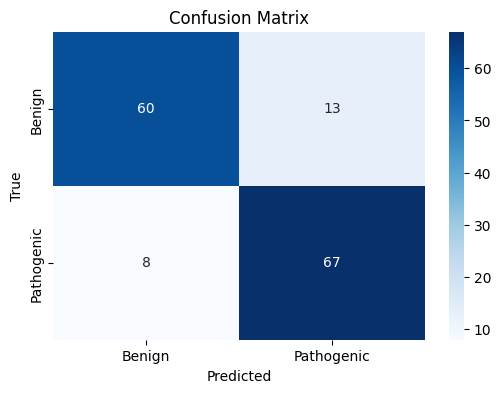

In [ ]:
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create data loaders
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

# Initialize optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# Training function
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Evaluation function
def evaluate(loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            preds.extend(pred.cpu().numpy())
            trues.extend(data.y.cpu().numpy())
    return accuracy_score(trues, preds), trues, preds

# Training loop with early stopping
best_acc = 0
patience = 10
counter = 0
for epoch in range(100):
    loss = train()
    train_acc, _, _ = evaluate(train_loader)
    test_acc, trues, preds = evaluate(test_loader)
    print(f'Epoch {epoch+1}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

    if test_acc > best_acc:
        best_acc = test_acc
        counter = 0
        # Save best model (optional)
        torch.save(model.state_dict(), 'best_gat_model.pth')
    else:
        counter += 1
    if counter >= patience:
        print("Early stopping")
        break

# Final evaluation
test_acc, trues, preds = evaluate(test_loader)
precision = precision_score(trues, preds)
recall = recall_score(trues, preds)
f1 = f1_score(trues, preds)
cm = confusion_matrix(trues, preds)

# Print metrics
print("\nFinal Performance Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Pathogenic'], yticklabels=['Benign', 'Pathogenic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
plt.savefig('confusion_matrix.png')
plt.close()

Total samples: 736
Positive (Pathogenic): 368
Negative (Benign): 368
Training samples: 588
Test samples: 148
Epoch 1, Loss: 0.6882, Train Acc: 0.8095, Test Acc: 0.7365
Epoch 2, Loss: 0.6510, Train Acc: 0.8265, Test Acc: 0.7838
Epoch 3, Loss: 0.5368, Train Acc: 0.8214, Test Acc: 0.7770
Epoch 4, Loss: 0.4080, Train Acc: 0.8418, Test Acc: 0.7770
Epoch 5, Loss: 0.3531, Train Acc: 0.8605, Test Acc: 0.7568
Epoch 6, Loss: 0.3093, Train Acc: 0.8690, Test Acc: 0.7770
Epoch 7, Loss: 0.2959, Train Acc: 0.8844, Test Acc: 0.7973
Epoch 8, Loss: 0.2787, Train Acc: 0.8980, Test Acc: 0.8176
Epoch 9, Loss: 0.2664, Train Acc: 0.8980, Test Acc: 0.8176
Epoch 10, Loss: 0.2554, Train Acc: 0.9014, Test Acc: 0.8041
Epoch 11, Loss: 0.2431, Train Acc: 0.9150, Test Acc: 0.8108
Epoch 12, Loss: 0.2587, Train Acc: 0.9048, Test Acc: 0.8176
Epoch 13, Loss: 0.2464, Train Acc: 0.9116, Test Acc: 0.8176
Epoch 14, Loss: 0.2271, Train Acc: 0.9099, Test Acc: 0.8176
Epoch 15, Loss: 0.2468, Train Acc: 0.9269, Test Acc: 0.8243


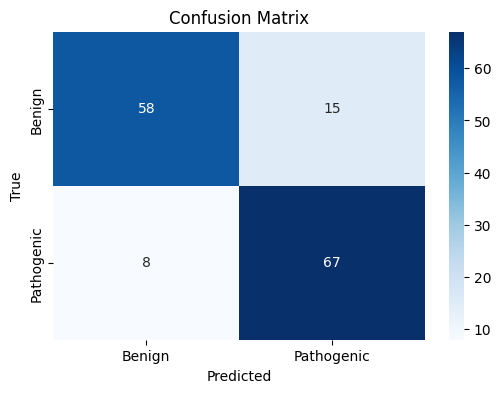

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Verify dataset size
print(f"Total samples: {len(balanced_graphs)}")
labels = [g.y.item() for g in balanced_graphs]
print(f"Positive (Pathogenic): {sum(labels)}")
print(f"Negative (Benign): {len(labels) - sum(labels)}")

# Split dataset (80% train, 20% test)
train_graphs, test_graphs = train_test_split(balanced_graphs, test_size=0.2, random_state=42)
print(f"Training samples: {len(train_graphs)}")
print(f"Test samples: {len(test_graphs)}")

# Create data loaders
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

# Define GAT model (same as previous definition)
class GATModel(torch.nn.Module):
    def __init__(self, input_dim=1024, hidden_dim=64, num_heads=4, dropout=0.1):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=num_heads, dropout=dropout)
        self.conv2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=dropout)
        self.fc = torch.nn.Linear(hidden_dim, 2)  # Binary classification
        self.dropout = dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Pooling
        x = self.fc(x)
        return x

# Initialize model
model = GATModel().to(device)

# Initialize optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# Training function
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Evaluation function
def evaluate(loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            preds.extend(pred.cpu().numpy())
            trues.extend(data.y.cpu().numpy())
    return accuracy_score(trues, preds), trues, preds

# Training loop with early stopping
best_acc = 0
#patience = 10
counter = 0
for epoch in range(100):
    loss = train()
    train_acc, _, _ = evaluate(train_loader)
    test_acc, trues, preds = evaluate(test_loader)
    print(f'Epoch {epoch+1}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

    if test_acc > best_acc:
        best_acc = test_acc
        counter = 0
        torch.save(model.state_dict(), 'best_gat_model.pth')
    else:
        counter += 1
    '''if counter >= patience:
        print("Early stopping")
        break'''

# Final evaluation
test_acc, trues, preds = evaluate(test_loader)
precision = precision_score(trues, preds)
recall = recall_score(trues, preds)
f1 = f1_score(trues, preds)
cm = confusion_matrix(trues, preds)

# Print metrics
print("\nFinal Performance Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Pathogenic'], yticklabels=['Benign', 'Pathogenic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()
plt.close()